In [374]:
pip install skforecast

     |████████████████████████████████| 81 kB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 76 kB 1.8 MB/s  eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [375]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import requests
import re
from bs4 import BeautifulSoup
from holidays_es import Province

# Análisis
# ==============================================================================
from statsmodels.tsa.seasonal import seasonal_decompose

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')

sns.set_context('poster')
sns.set(rc={'figure.figsize': (14., 8.)})
sns.set_style('whitegrid')


# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

## 0 - Obtención y limpieza de datos 

In [99]:
temperatura = pd.read_excel('../data/AEMET_temperature_data_2014-2020.xlsx', parse_dates=[0])

In [100]:
temperatura.rename(columns={'Unnamed: 0': 'date', 'T (ºC)': 'Temperature'}, inplace=True)

In [106]:
temperatura.head()

,date,Temperature
0,2014-01-01,11.48750
1,2014-01-02,13.08750
2,2014-01-03,14.43125
3,2014-01-04,11.98125
4,2014-01-05,10.94375


In [105]:
temperatura.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2557 entries, 0 to 2556
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         2557 non-null   datetime64[ns]
 1   Temperature  2557 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 40.1 KB


In [107]:
temperatura.set_index('date',inplace=True)

In [108]:
temperatura.head()

,Temperature
date,
2014-01-01,11.48750
2014-01-02,13.08750
2014-01-03,14.43125
2014-01-04,11.98125
2014-01-05,10.94375


<AxesSubplot:xlabel='date'>

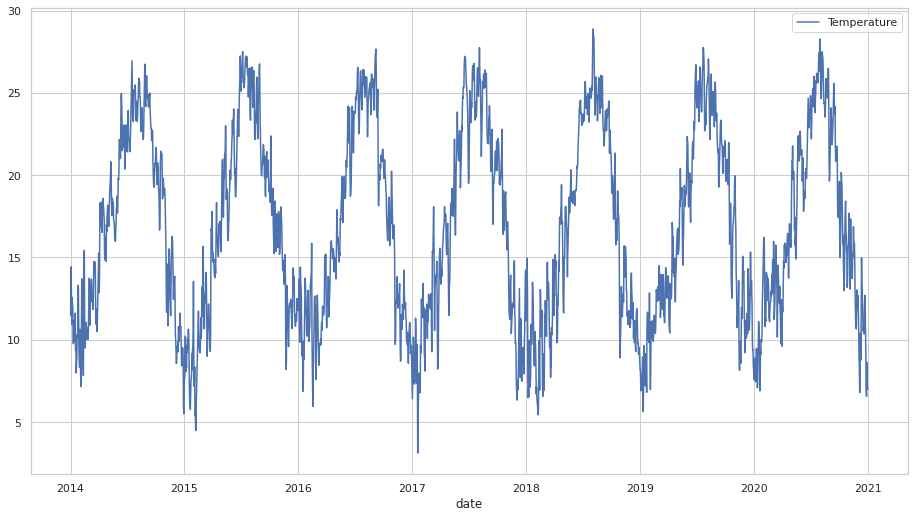

In [126]:
sns.lineplot(data=temperatura)

In [174]:
demanda = pd.read_csv('../data/export_DemandaReal_2022-02-28_20_21.csv', sep=';', parse_dates=[5])

In [175]:
demanda.head()

,id,name,geoid,geoname,value,datetime
0,1293,Demanda real,NaN,NaN,23021.076389,2014-01-01 00:00:00+01:00
1,1293,Demanda real,NaN,NaN,28191.597222,2014-01-02 00:00:00+01:00
2,1293,Demanda real,NaN,NaN,28465.180556,2014-01-03 00:00:00+01:00
3,1293,Demanda real,NaN,NaN,26860.493056,2014-01-04 00:00:00+01:00
4,1293,Demanda real,NaN,NaN,25333.597222,2014-01-05 00:00:00+01:00


In [176]:
demanda.datetime=pd.to_datetime(demanda['datetime'], utc=True)

In [177]:
demanda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2557 entries, 0 to 2556
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   id        2557 non-null   int64              
 1   name      2557 non-null   object             
 2   geoid     0 non-null      float64            
 3   geoname   0 non-null      float64            
 4   value     2557 non-null   float64            
 5   datetime  2557 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), float64(3), int64(1), object(1)
memory usage: 120.0+ KB


In [178]:
demanda.datetime=pd.to_datetime(demanda['datetime'], utc=True)

In [179]:
demanda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2557 entries, 0 to 2556
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   id        2557 non-null   int64              
 1   name      2557 non-null   object             
 2   geoid     0 non-null      float64            
 3   geoname   0 non-null      float64            
 4   value     2557 non-null   float64            
 5   datetime  2557 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), float64(3), int64(1), object(1)
memory usage: 120.0+ KB


In [188]:
demanda['date'] =demanda.datetime.dt.date

In [195]:
demanda = demanda[['date', 'value']]

In [192]:
demanda.date = pd.to_datetime(demanda.date)

In [196]:
demanda.head()

,date,value
0,2013-12-31,23021.076389
1,2014-01-01,28191.597222
2,2014-01-02,28465.180556
3,2014-01-03,26860.493056
4,2014-01-04,25333.597222


In [197]:
demanda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2557 entries, 0 to 2556
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2557 non-null   datetime64[ns]
 1   value   2557 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 40.1 KB


In [199]:
demanda.set_index('date',inplace=True)

In [200]:
demanda.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2557 entries, 2013-12-31 to 2020-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   2557 non-null   float64
dtypes: float64(1)
memory usage: 40.0 KB


<AxesSubplot:xlabel='date'>

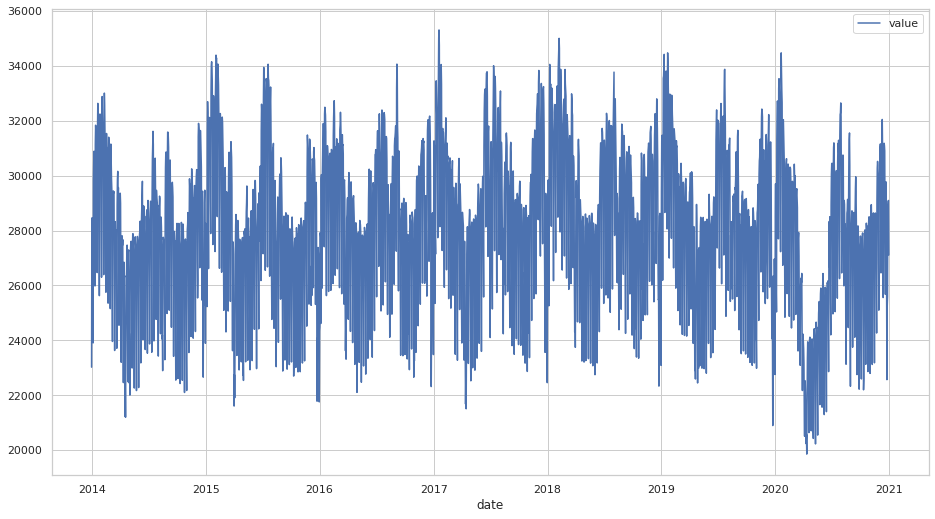

In [201]:
sns.lineplot(data=demanda)

In [202]:
demanda.head()

,value
date,
2013-12-31,23021.076389
2014-01-01,28191.597222
2014-01-02,28465.180556
2014-01-03,26860.493056
2014-01-04,25333.597222


In [205]:
temp_dem = pd.merge(temperatura, demanda, left_index=True, right_index=True)

In [207]:
temp_dem

,Temperature,value
date,,
2014-01-01,11.48750,28191.597222
2014-01-02,13.08750,28465.180556
2014-01-03,14.43125,26860.493056
2014-01-04,11.98125,25333.597222
2014-01-05,10.94375,23905.541667
...,...,...
2020-12-26,6.85000,25605.138889
2020-12-27,6.55625,28812.750000
2020-12-28,8.61875,29063.493056


In [244]:
def is_business_day(date):
    return bool(len(pd.bdate_range(date, date)))

In [246]:
is_business_day(temp_dem.index[0])

True

In [259]:
def business_days(df):
    buss_day = []
    for i in range(len(df.index)):
        
        if is_business_day(df.index[i]):
            buss_day.append(1)
        else:
            buss_day.append(0)
    return buss_day

In [261]:
temp_dem['Laborable'] = business_days(temp_dem)

In [263]:
temp_dem.head(15)

,Temperature,value,Laborable
date,,,
2014-01-01,11.487500,28191.597222,1
2014-01-02,13.087500,28465.180556,1
2014-01-03,14.431250,26860.493056,1
2014-01-04,11.981250,25333.597222,0
2014-01-05,10.943750,23905.541667,0
2014-01-06,12.566667,29859.201389,1
2014-01-07,12.133333,30573.444444,1
2014-01-08,12.037500,30887.750000,1
2014-01-09,10.387500,30847.819444,1


In [273]:
temp_dem.corr()

,Temperature,value,Laborable
Temperature,1.000000,-0.099375,-0.001064
value,-0.099375,1.000000,0.357723
Laborable,-0.001064,0.357723,1.000000


In [272]:
temp_dem.index

DatetimeIndex(['2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04',
               '2014-01-05', '2014-01-06', '2014-01-07', '2014-01-08',
               '2014-01-09', '2014-01-10',
               ...
               '2020-12-21', '2020-12-22', '2020-12-23', '2020-12-24',
               '2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28',
               '2020-12-29', '2020-12-30'],
              dtype='datetime64[ns]', name='date', length=2556, freq=None)

In [274]:
infer_ = pd.infer_freq(temp_dem.index)

In [275]:
infer_

'D'

In [276]:
temp_dem.index.freq = infer_

In [277]:
temp_dem.index

DatetimeIndex(['2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04',
               '2014-01-05', '2014-01-06', '2014-01-07', '2014-01-08',
               '2014-01-09', '2014-01-10',
               ...
               '2020-12-21', '2020-12-22', '2020-12-23', '2020-12-24',
               '2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28',
               '2020-12-29', '2020-12-30'],
              dtype='datetime64[ns]', name='date', length=2556, freq='D')

## 1.- Análisis Exploratorio de los Datos (EDA)

### 1.1. Separación de los datos en train, validation y test

In [327]:
# temp_dem = temp_dem.loc['2014-01-01': '2018-12-31']ç
fin_train = '2018-12-31'
fin_validacion = '2019-11-30'
temp_dem_train = temp_dem.loc[: fin_train, :]
temp_dem_val   = temp_dem.loc[fin_train:fin_validacion, :]
temp_dem_test  = temp_dem.loc[fin_validacion:, :]

print(f"Fechas train      : {temp_dem_train.index.min()} --- {temp_dem_train.index.max()}")
print(f"Fechas validacion : {temp_dem_val.index.min()} --- {temp_dem_val.index.max()}")
print(f"Fechas test       : {temp_dem_test.index.min()} --- {temp_dem_test.index.max()}")

Fechas train      : 2014-01-01 00:00:00 --- 2018-12-31 00:00:00
Fechas validacion : 2018-12-31 00:00:00 --- 2019-11-30 00:00:00
Fechas test       : 2019-11-30 00:00:00 --- 2020-12-30 00:00:00


In [328]:
temp_dem_train.tail()

,Temperature,value,Laborable
date,,,
2018-12-27,9.12500,28624.194444,1
2018-12-28,9.55625,26632.840278,1
2018-12-29,9.33750,25255.055556,0
2018-12-30,9.12500,25908.576389,0
2018-12-31,8.67500,23086.638889,1


### 1.2.-Análisis de la temperatura

In [329]:
temp = temp_dem_train[['Temperature']]

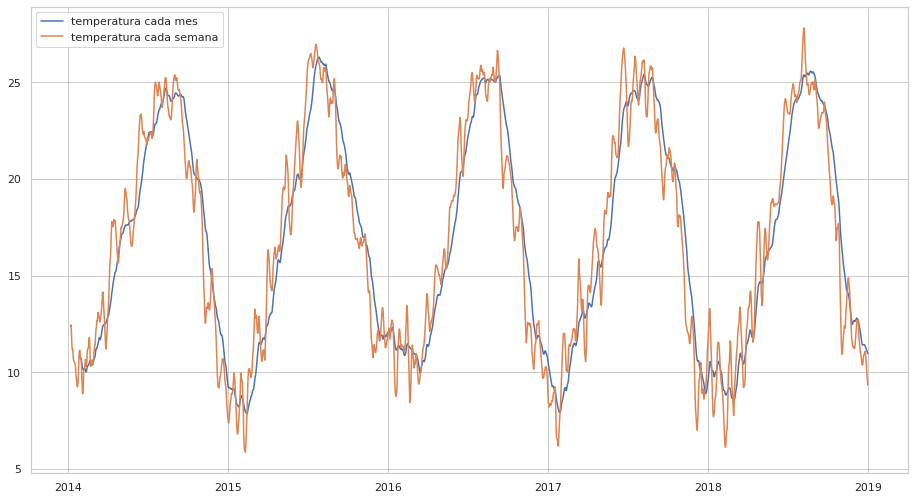

In [330]:
plt.plot(temp.rolling(window=30).mean(), label='temperatura cada mes')
plt.plot(temp.rolling(window=7).mean(), label='temperatura cada semana')
plt.legend();

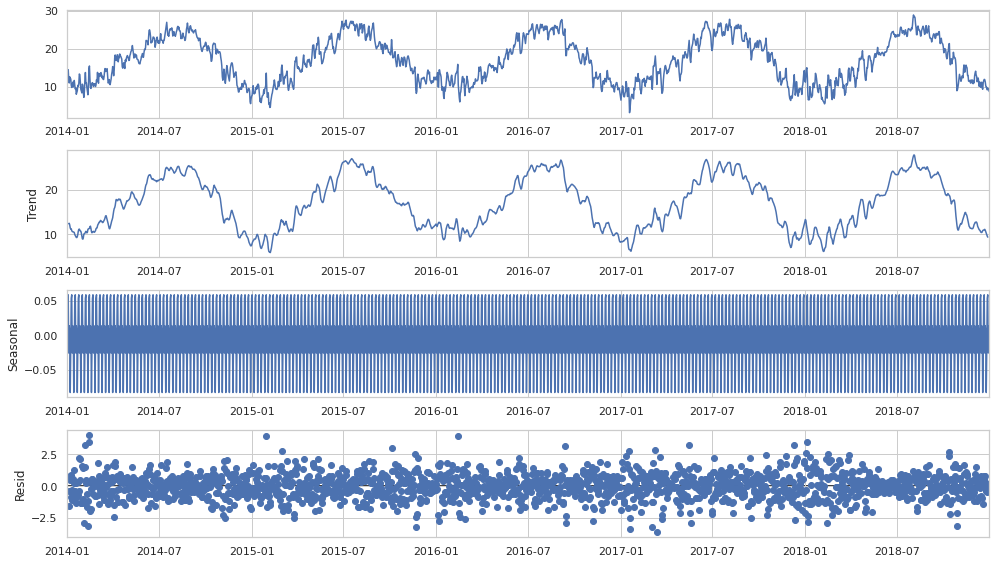

In [331]:
temp_des = seasonal_decompose(temp, model="additive")
temp_des.plot();

Se puede apreciar como las temperaturas son más altas en verano y menos en invierno y como este patrón se repite cada año. También podemos observar como hay más cantidad de picos de temperaturas altas que bajas en los residuos.

Sin embargo no se aprecia bien la estacionalidad, así que probaremos a hacer este estudio con temperaturas mensuales en vez de diarias.

In [340]:
temperatura_mensual = temp.rolling(window=30).mean()
temperatura_mensual2=temperatura_mensual.tail(1797)
temperatura_mensual2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1797 entries, 2014-01-30 to 2018-12-31
Freq: D
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  1797 non-null   float64
dtypes: float64(1)
memory usage: 28.1 KB


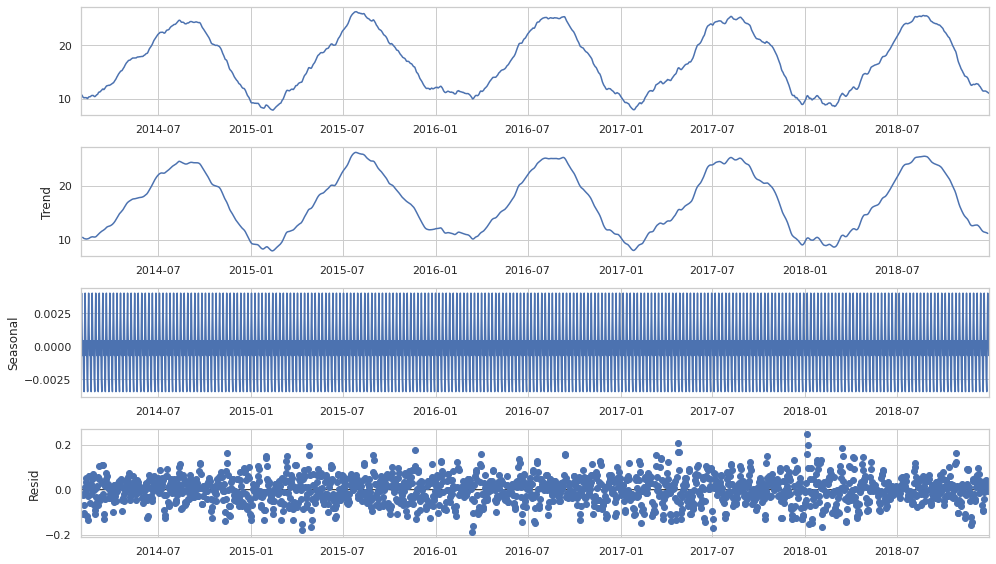

In [341]:
temp_des2 = seasonal_decompose(temperatura_mensual2, model="additive")
temp_des2.plot();

### 1.3.- Análisis de la demanda energética

In [342]:
demanda = temp_dem_train[['value']]

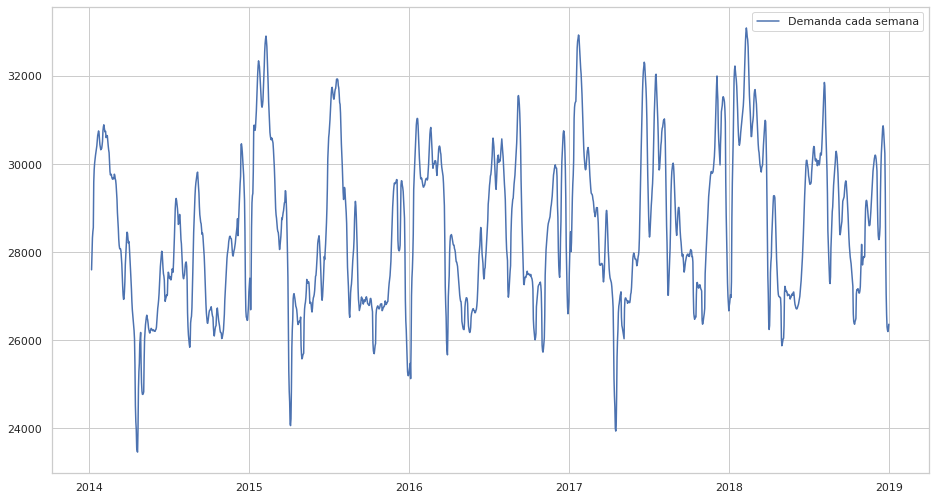

In [343]:
# plt.plot(demanda.rolling(window=30).mean(), label='Demanda cada mes')
plt.plot(demanda.rolling(window=7).mean(), label='Demanda cada semana')
plt.legend();

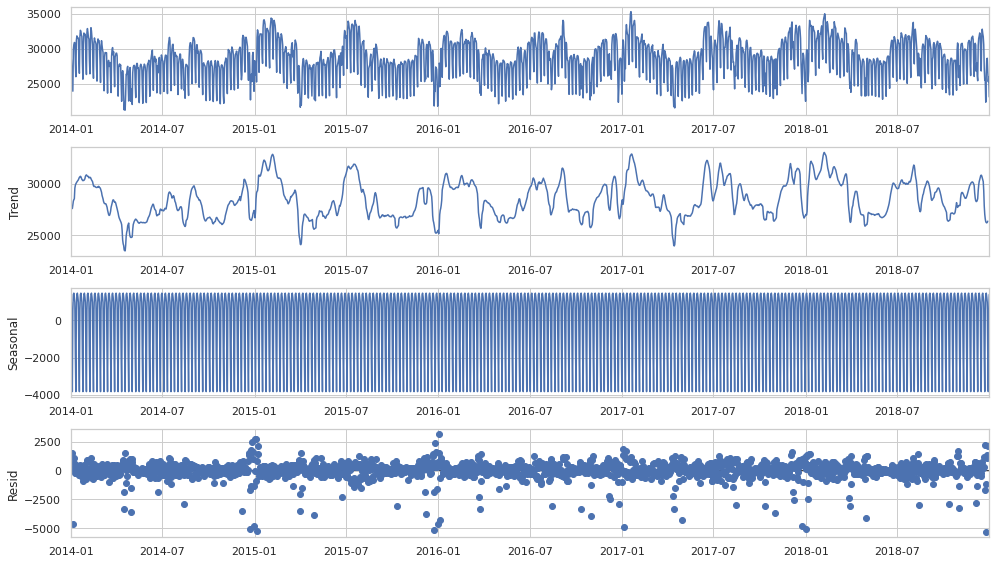

In [344]:
dem_des = seasonal_decompose(demanda, model="additive")
dem_des.plot();

Se pueden observar más residuos a la baja que al alza. Esto viene originado por los días festivos tanto regionales como nacionales que reducen la demanda energética. Sobre todo se observan a finales de diciembre y principios de enero por las vacaciones de esas fechas.

Por otro lado, se puede apreciar claramente un descenso en la tendencia en 2020, sobre todo entre marzo y junio mas o menos, debido a la pandemia provocada por el coronavirus.

Finalmente podemos observar como, con la excepción del año 2020 por lo comentado anteriormente, existe una pequeña tendencia al alza en la demanda.

Como con la temepratura, vamos a realizar este estudio con valores de demandan mensual y también semanal.

In [345]:
demanda_semanal = demanda.rolling(window=7).mean()

In [347]:
demanda_semanal2=demanda_semanal.tail(1820)
demanda_semanal2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1820 entries, 2014-01-07 to 2018-12-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   1820 non-null   float64
dtypes: float64(1)
memory usage: 28.4 KB


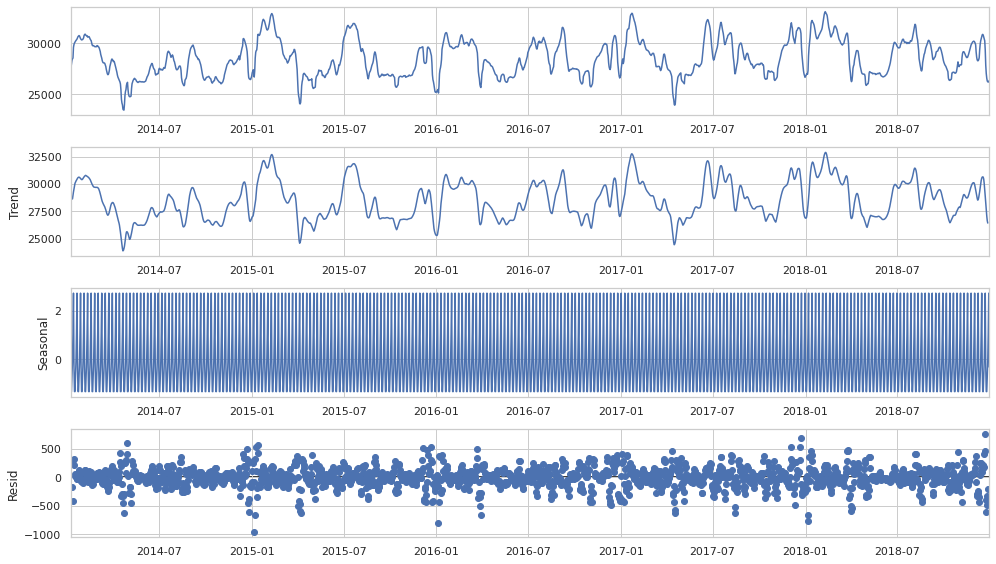

In [348]:
# demanda_semanal = demanda.rolling(window=7).mean()
dem_des1 = seasonal_decompose(demanda_semanal2, model="additive")
dem_des1.plot();

En este gráfico vemos como el número de outliers en el ruido es menos que en el gráfico diario ya que los festivos se diluyen en la semana.

In [350]:
demanda_mensual = demanda.rolling(window=30).mean()
demanda_mensual2=demanda_mensual.tail(1797)
demanda_mensual2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1797 entries, 2014-01-30 to 2018-12-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   1797 non-null   float64
dtypes: float64(1)
memory usage: 28.1 KB


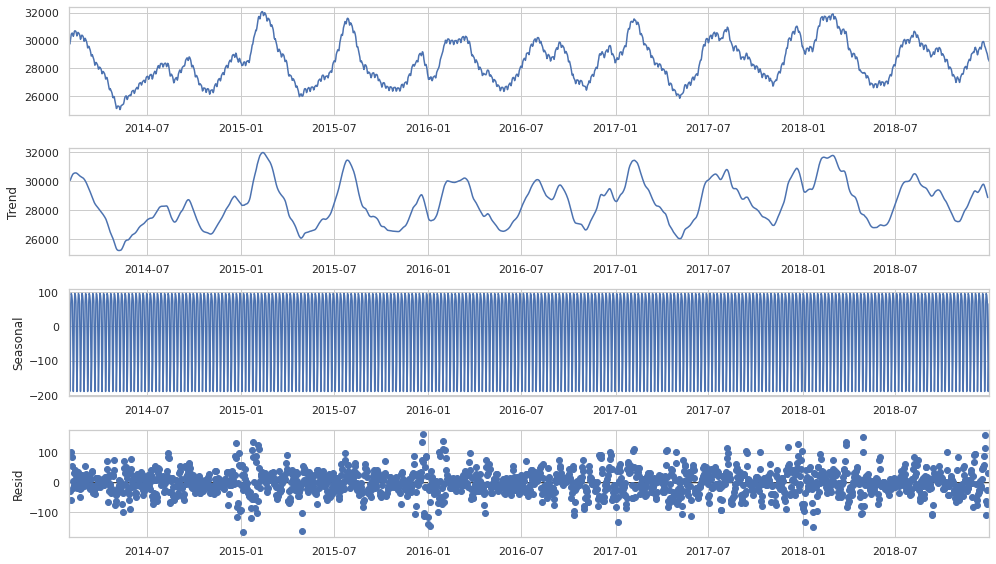

In [351]:
dem_des2 = seasonal_decompose(demanda_mensual2, model="additive")
dem_des2.plot();

#### 1.3.1.- Análisis de la estacionalida de la demanda

/tmp/ipykernel_1793/3737303473.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demanda['mes'] = demanda.index.month


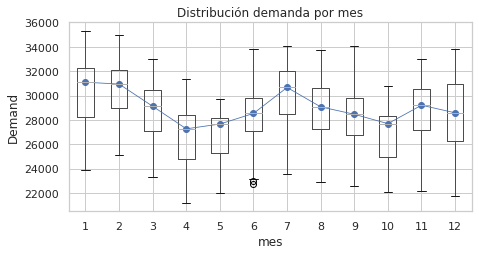

In [352]:
fig, ax = plt.subplots(figsize=(7, 3.5))
demanda['mes'] = demanda.index.month
demanda.boxplot(column='value', by='mes', ax=ax,)
demanda.groupby('mes')['value'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por mes')
fig.suptitle('');

Se observa una estacionalidad anual con valores pico de demanda en enero, febrero y julio.


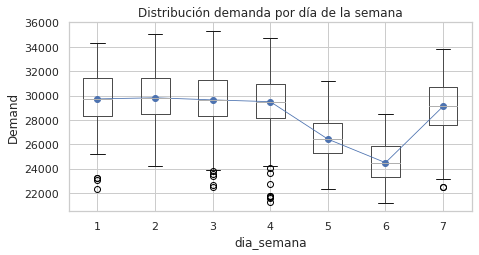

In [357]:
fig, ax = plt.subplots(figsize=(7, 3.5))
demanda['dia_semana'] = demanda.index.day_of_week+1
demanda.boxplot(column='value', by='dia_semana', ax=ax)
demanda.groupby('dia_semana')['value'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por día de la semana')
fig.suptitle('');

Se observa una diferencia de demanda más baja en viernes y sábados. Este dato hace sospechar ya que lo normal sería que la demanda fuese menor en sábados y domingos al ser días no lavorables. Sin embargo se ha comprobado que los días están correctamente etiquetados.

In [359]:
demanda

,value,mes,dia_semana
date,,,
2014-01-01,28191.597222,1,3
2014-01-02,28465.180556,1,4
2014-01-03,26860.493056,1,5
2014-01-04,25333.597222,1,6
2014-01-05,23905.541667,1,7
...,...,...,...
2018-12-27,28624.194444,12,4
2018-12-28,26632.840278,12,5
2018-12-29,25255.055556,12,6


In [361]:
demanda_lab = temp_dem_train[['value', 'Laborable']]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.5))
sns.violinplot(
    x       = 'value',
    y       = 'Laborable',
    data    = demanda_lab.assign(Holiday = demanda_lab.Laborable.astype(str)),
    palette = 'tab10',
    ax      = ax
)
ax.set_title('Distribución de la demanda entre festivos y no festivos')
ax.set_xlabel('demanda')
ax.set_ylabel('festivo');

## 2.- Selección del modelo

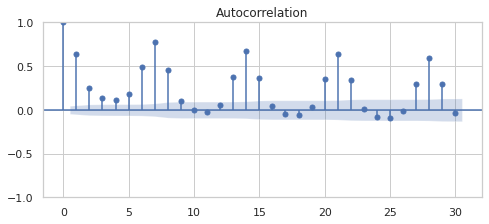

In [366]:
fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(demanda.value, ax=ax, lags=30)
plt.show()

/home/cleonortiz/anaconda3/envs/modelo/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


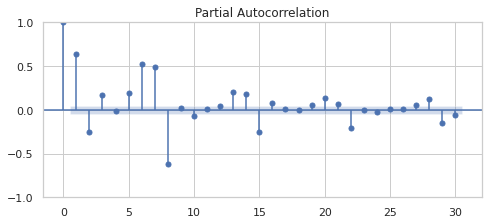

In [367]:
fig, ax = plt.subplots(figsize=(7, 3))
plot_pacf(demanda.value, ax=ax, lags=30)
plt.show()

Los gráficos de autocorrelación y de autocorrelación parcial indican una clara asociación entre la demanda energética de un dia y del anterior así como de un dia y del mismo día del mes anterior. Por lo tanto es una buena idea usar un modelo autorregresivo.

## 3.- Entrenamiento, validación y test del modelo

### 3.1. Modelo usando solo la demanda

Se crea y entrena un modelo autorregresivo recursivo (ForecasterAutoreg) a partir de un modelo de regresión lineal con penalización Ridge y una ventana temporal de 30 lags. Esto último significa que, para cada predicción, se utilizan como predictores la demanda de los 30 días anteriores.

In [404]:
forecaster = ForecasterAutoreg(
                regressor = make_pipeline(StandardScaler(), Ridge()),
                lags      = 30
             )

forecaster.fit(y=temp_dem.loc[:fin_train, 'value'])
forecaster


ForecasterAutoreg 
Regressor: Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
Window size: 30 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2014-01-01 00:00:00'), Timestamp('2018-12-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'ridge__alpha': 1.0, 'ridge__copy_X': True, 'ridge__fit_intercept': True, 'ridge__max_iter': None, 'ridge__normalize': 'deprecated', 'ridge__positive': False, 'ridge__random_state': None, 'ridge__solver': 'auto', 'ridge__tol': 0.001} 
Creation date: 2022-03-01 16:18:55 
Last fit date: 2022-03-01 16:18:55 
Skforecast version: 0.4.2 

In [405]:
metrica, predicciones = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = temp_dem.value,
                            initial_train_size = len(temp_dem.loc[:fin_train]),
                            steps      = 30,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                        )

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1826
Number of observations used for backtesting: 730
    Number of folds: 25
    Number of steps per fold: 30
    Last fold only includes 10 observations

Data partition in fold: 0
    Training:   2014-01-01 00:00:00 -- 2018-12-31 00:00:00
    Validation: 2019-01-01 00:00:00 -- 2019-01-30 00:00:00
Data partition in fold: 1
    Training:   2014-01-01 00:00:00 -- 2018-12-31 00:00:00
    Validation: 2019-01-31 00:00:00 -- 2019-03-01 00:00:00
Data partition in fold: 2
    Training:   2014-01-01 00:00:00 -- 2018-12-31 00:00:00
    Validation: 2019-03-02 00:00:00 -- 2019-03-31 00:00:00
Data partition in fold: 3
    Training:   2014-01-01 00:00:00 -- 2018-12-31 00:00:00
    Validation: 2019-04-01 00:00:00 -- 2019-04-30 00:00:00
Data partition in fold: 4
    Training:   2014-01-01 00:00:00 -- 2018-12-31 00:00:00
    Validation: 2019-05-01 00:00:00 -- 201

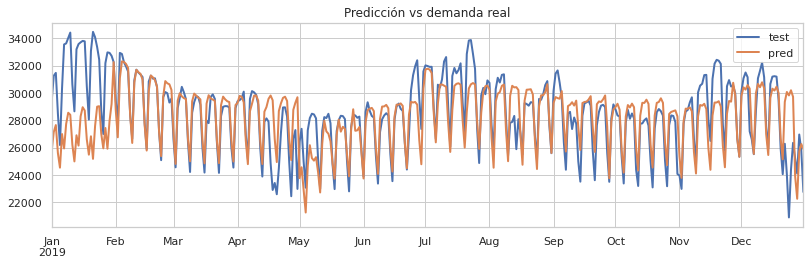

In [406]:
fig, ax = plt.subplots(figsize=(12, 3.5))
temp_dem.loc[predicciones.index[:365], 'value'].plot(ax=ax, linewidth=2, label='test')
predicciones[:365].plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

In [407]:
print(f'Error backtest: {metrica}')

Error backtest: [1599.73176991]


En las comaprativas entre la predicción y la demanda real, podemos observar que el modelo se ajusta medianamente bien a lo largo del año excepto en el mes de enero. Si miramos las gráficas de demanda energética y de temperatura, observamos que en enero de 2016, la demanda energética fue menor que en enero de otros años, lo que se ocasionó debido a una temperatura mayor a la de otros años en enero de 2016. Esto es lo que puede estar ocasionando esta distorsión en la predicción.

Por otro lado, se pueden ajustar los hiperparámetros del modelo mediante una optimizacion de los mismos usando GridSearch.

#### *Realizamos un GridSearch para obtener los mejores parámetros*

In [408]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = make_pipeline(StandardScaler(), Ridge()),
                    lags      = 30 # Este valor será remplazado en el grid search
              )

# Hiperparámetros del regresor
param_grid = {'ridge__alpha': np.logspace(-3, 5, 10)}

# Lags utilizados como predictores
lags_grid = [7, 30, [1, 2, 3, 23, 24, 25, 47, 48, 49]]

resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = temp_dem.loc[:fin_validacion, 'value'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 30,
                        metric      = 'mean_absolute_error',
                        refit       = False,
                        initial_train_size = len(temp_dem[:fin_train]),
                        return_best = True,
                        verbose     = False
                  )

Number of models compared: 30


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:05<00:00,  1.88s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
  Parameters: {'ridge__alpha': 215.44346900318823}
  Backtesting metric: 1314.206979054466



In [418]:
resultados_grid

,lags,params,metric,ridge__alpha
16,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 215.44346900318823},1314.206979,215.443469
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 27.825594022071257},1345.753898,27.825594
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 3.593813663804626},1357.642706,3.593814
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 0.46415888336127775},1359.541582,0.464159
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 0.05994842503189409},1359.792387,0.059948
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 0.007742636826811269},1359.824875,0.007743
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 0.001},1359.829072,0.001000
17,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 1668.1005372000557},1407.912061,1668.100537
18,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 12915.496650148827},1770.049395,12915.496650
6,"[1, 2, 3, 4, 5, 6, 7]",{'ridge__alpha': 215.44346900318823},1774.118485,215.443469


In [419]:
best_lag = resultados_grid['lags'][16]
best_alpha = resultados_grid['ridge__alpha'][16]

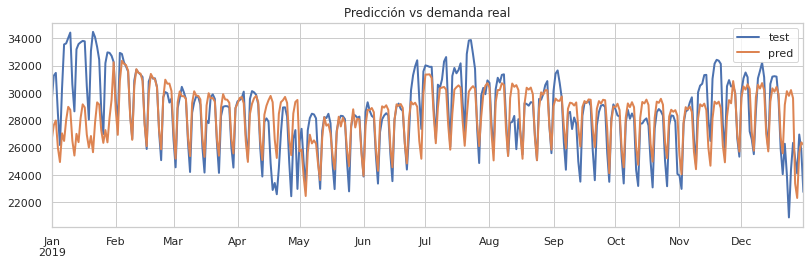

In [410]:
metrica, predicciones = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = temp_dem.value,
                            initial_train_size = len(temp_dem[:fin_train]),
                            steps      = 30,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = False
                        )


fig, ax = plt.subplots(figsize=(12, 3.5))
temp_dem.loc[predicciones.index[:365], 'value'].plot(linewidth=2, label='test', ax=ax)
predicciones[:365].plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();



In [411]:
print(f'Error backtest: {metrica}')

Error backtest: [1585.37813868]




Gracias a los parámetros obtenidos mediante el GridSearch hemos bajado el error de 1599.73 a 1585.38.

Aún así es un error bastante alto, por lo que vamos a introducir variables exógenas como la temperatura y el día laborable para ajustar más el modelo.

### 3.2. Modelo usando variables exógenas (temperatura y laboralidad)